In [2]:
import os
from pathlib import Path
import re
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim import corpora
import gensim
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# NLP tools
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Download NLTK stopwords once if needed
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
DATA_DIR = r"C:/Users/natna/Downloads/KAIM WEEK-1 CHALLENGE/Predicting-Price-Moves-with-News-Sentiment/data/raw_analyst_ratings.csv"
DATA_DIR = Path(DATA_DIR)
# Replace filename below with actual CSV name if different; we'll try to auto-detect.
csv_candidates = list(DATA_DIR.glob("*.csv"))
print("CSV files found:", [p.name for p in csv_candidates])

CSV files found: []


In [4]:
df = pd.read_csv("C:/Users/natna/Downloads/KAIM WEEK-1 CHALLENGE/Predicting-Price-Moves-with-News-Sentiment/data/raw_analyst_ratings.csv", low_memory=False)
print("Data shape:", df.shape)
display(df.head(3))
display(df.info())

Data shape: (1407328, 6)


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


None

In [5]:
df.columns = [c.strip().lower() for c in df.columns]

In [6]:
text_cols = [c for c in df.columns if re.search(r"headline|title|summary|text|body", c)]
publisher_cols = [c for c in df.columns if re.search(r"publisher|source|site|author", c)]
date_cols = [c for c in df.columns if re.search(r"date|published|timestamp|time", c)]

print("Text columns candidates:", text_cols)
print("Publisher columns candidates:", publisher_cols)
print("Date columns candidates:", date_cols)

# Pick primary columns heuristically
TEXT_COL = text_cols[0] if text_cols else df.columns[0]
PUBLISHER_COL = publisher_cols[0] if publisher_cols else None
DATE_COL = date_cols[0] if date_cols else None

print("Selected TEXT_COL:", TEXT_COL)
print("Selected PUBLISHER_COL:", PUBLISHER_COL)
print("Selected DATE_COL:", DATE_COL)

# %% SIMPLE PREVIEW: missing values
print("Missing values (top columns):")
print(df.isnull().sum().sort_values().tail(10))

Text columns candidates: ['headline']
Publisher columns candidates: ['publisher']
Date columns candidates: ['date']
Selected TEXT_COL: headline
Selected PUBLISHER_COL: publisher
Selected DATE_COL: date
Missing values (top columns):
unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64


Character length stats:
 count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: char_len, dtype: float64

Word length stats:
 count    1.407328e+06
mean     1.141671e+01
std      6.352997e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      7.700000e+01
Name: word_len, dtype: float64


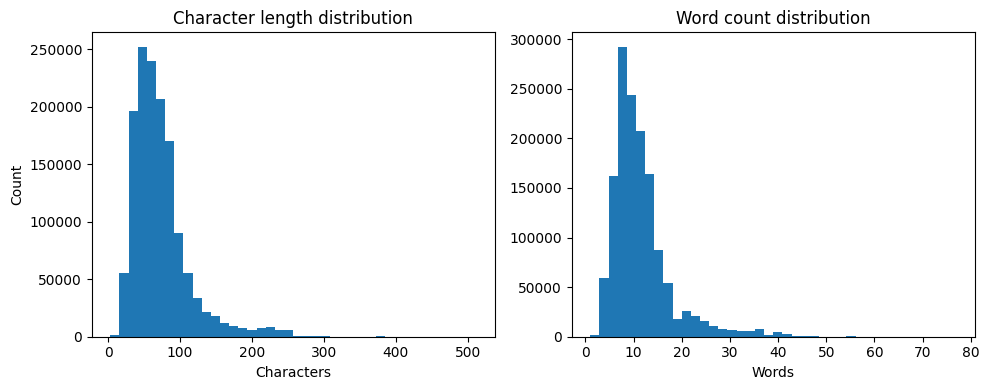

,publisher,count
0,Paul Quintaro,228373
1,Lisa Levin,186979
2,Benzinga Newsdesk,150484
3,Charles Gross,96732
4,Monica Gerson,82380
5,Eddie Staley,57254
6,Hal Lindon,49047
7,ETF Professor,28489
8,Juan Lopez,28438
9,Benzinga Staff,28114


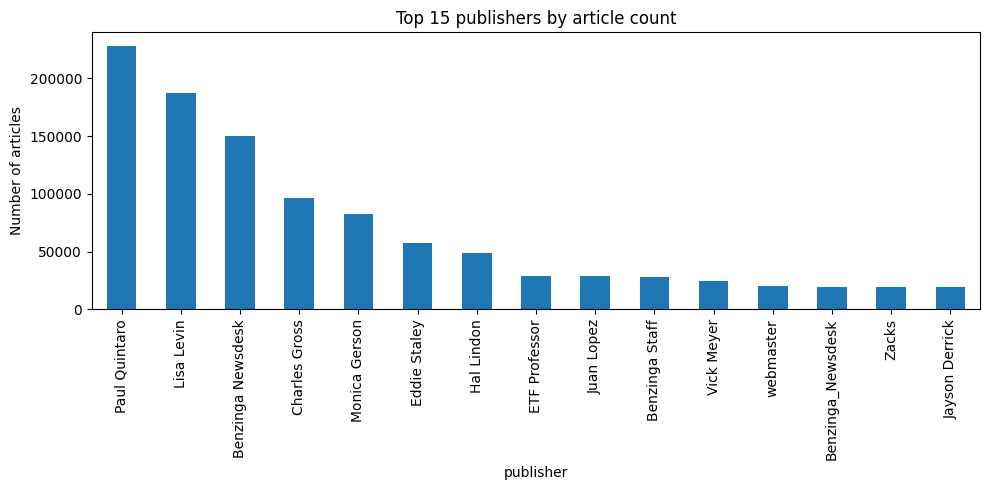

In [7]:
# %% DESCRIPTIVE STATISTICS: headline/text lengths
# create a column for text we will analyze: prefer headline/title; if not present use summary/body
df['text_for_analysis'] = df[TEXT_COL].astype(str)  # safe string conversion

# compute lengths (characters and words)
df['char_len'] = df['text_for_analysis'].str.len()
df['word_len'] = df['text_for_analysis'].str.split().apply(len)

# Basic stats
desc_char = df['char_len'].describe()
desc_word = df['word_len'].describe()
print("Character length stats:\n", desc_char)
print("\nWord length stats:\n", desc_word)

# Histogram of headline length (characters) and word length
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['char_len'].dropna(), bins=40)
plt.title('Character length distribution')
plt.xlabel('Characters')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(df['word_len'].dropna(), bins=40)
plt.title('Word count distribution')
plt.xlabel('Words')
plt.tight_layout()
plt.show()

# %% PUBLISHER COUNTS
if PUBLISHER_COL:
    df[PUBLISHER_COL] = df[PUBLISHER_COL].astype(str).str.strip()
    publisher_counts = df[PUBLISHER_COL].value_counts().reset_index()
    publisher_counts.columns = ['publisher', 'count']
    display(publisher_counts.head(20))

    # Bar plot of top 15 publishers
    top = publisher_counts.head(15).set_index('publisher')
    plt.figure(figsize=(10,5))
    top['count'].plot(kind='bar')
    plt.title('Top 15 publishers by article count')
    plt.ylabel('Number of articles')
    plt.tight_layout()
    plt.show()
else:
    print("No publisher column found. If publisher column exists, rename it to include 'publisher' or 'source' etc.")

Parsed dates count (non-null): 55987


,published_parsed
0,2020-06-05 14:30:54+00:00
1,2020-06-03 14:45:20+00:00
2,2020-05-26 08:30:07+00:00
3,2020-05-22 16:45:06+00:00
4,2020-05-22 15:38:59+00:00


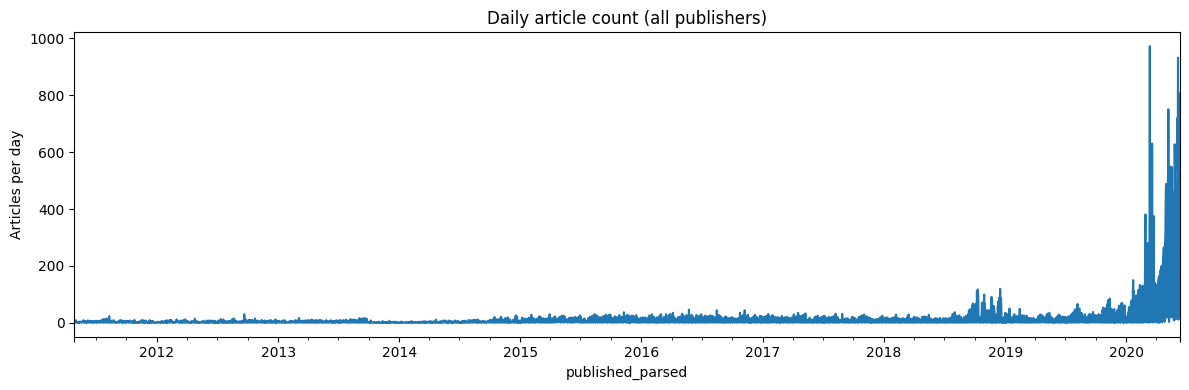

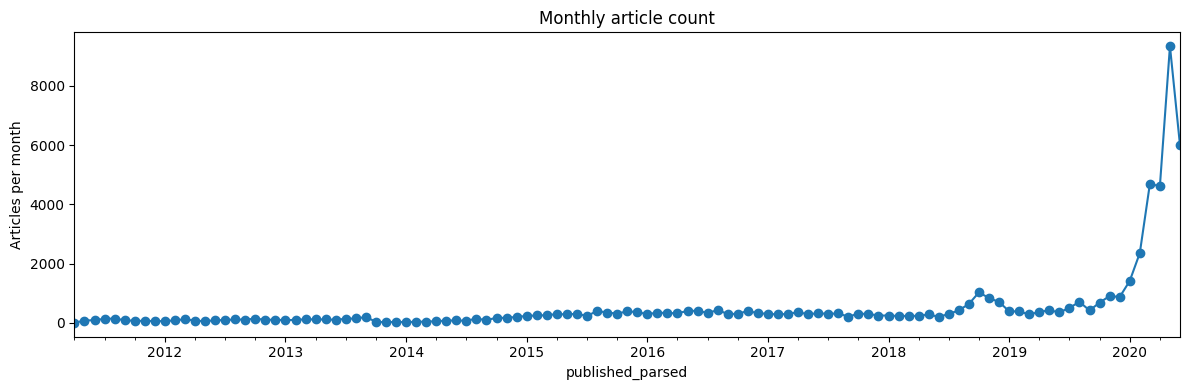

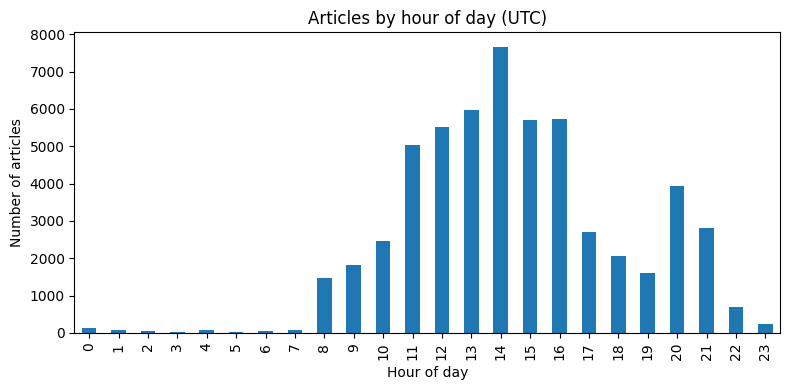

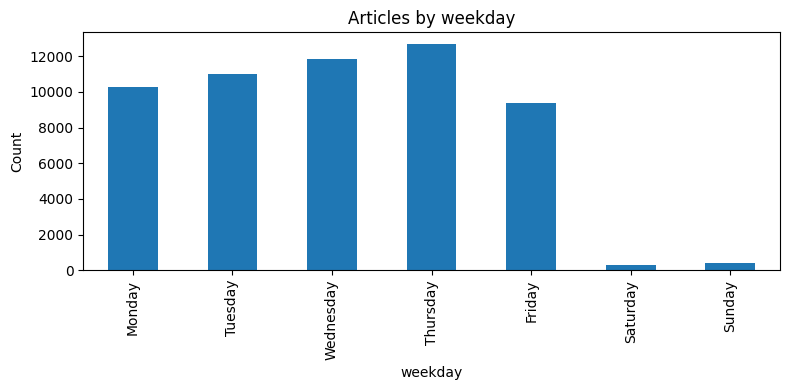

Top 10 days by article count:
 date
2020-03-12    973
2020-06-05    932
2020-06-10    807
2020-06-09    803
2020-06-08    765
2020-05-07    751
2020-06-03    720
2020-03-19    630
2020-05-26    628
2020-05-13    549
Name: count, dtype: int64


In [8]:
# %% DATE ANALYSIS: parse date column and create time series
if DATE_COL:
    # try parsing with pandas to_datetime; coerce errors
    df['published_parsed'] = pd.to_datetime(df[DATE_COL], errors='coerce', utc=True)
    # if parsed DST / timezone noisy, convert to local naive in +03:00 if desired:
    # df['published_local'] = df['published_parsed'].dt.tz_convert('Africa/Addis_Ababa').dt.tz_localize(None)
    # But we'll work in UTC and also show local hour if parsed
    print("Parsed dates count (non-null):", df['published_parsed'].notnull().sum())
    display(df[['published_parsed']].head())

    # Drop rows with no parsed date for time analysis
    df_time = df.dropna(subset=['published_parsed']).copy()
    df_time['published_parsed'] = pd.to_datetime(df_time['published_parsed'], utc=True)
    df_time['date'] = df_time['published_parsed'].dt.date
    df_time['hour'] = df_time['published_parsed'].dt.hour
    df_time['weekday'] = df_time['published_parsed'].dt.day_name()

    # Plot daily article counts (resample)
    daily = df_time.set_index('published_parsed').resample('D').size()
    plt.figure(figsize=(12,4))
    daily.plot()
    plt.title('Daily article count (all publishers)')
    plt.ylabel('Articles per day')
    plt.tight_layout()
    plt.show()

    # Weekly & monthly trends
    monthly = df_time.set_index('published_parsed').resample('M').size()
    plt.figure(figsize=(12,4))
    monthly.plot(marker='o')
    plt.title('Monthly article count')
    plt.ylabel('Articles per month')
    plt.tight_layout()
    plt.show()

    # Hour of day distribution (what time news are published)
    plt.figure(figsize=(8,4))
    df_time['hour'].value_counts().sort_index().plot(kind='bar')
    plt.title('Articles by hour of day (UTC)')
    plt.xlabel('Hour of day')
    plt.ylabel('Number of articles')
    plt.tight_layout()
    plt.show()

    # Weekday distribution
    plt.figure(figsize=(8,4))
    order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    weekday_counts = df_time['weekday'].value_counts().reindex(order)
    weekday_counts.plot(kind='bar')
    plt.title('Articles by weekday')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # Show days with spikes: top 10 days by count
    top_days = df_time['date'].value_counts().head(10)
    print("Top 10 days by article count:\n", top_days)
else:
    print("No date column identified. If there's a date column, rename it to include 'date' or 'published' or specify DATE_COL manually.")

In [9]:
import pandas as pd

# Replace this path with the actual path to your CSV
FILE_PATH = r"C:\Users\natna\Downloads\KAIM WEEK-1 CHALLENGE\Predicting-Price-Moves-with-News-Sentiment\data\raw_analyst_ratings.csv"

# Load CSV into DataFrame
df = pd.read_csv(FILE_PATH, low_memory=False)

# Check the first rows
df.head()


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [10]:
import unicodedata
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    if pd.isna(text): 
        return ""
    text = str(text)
    # normalize unicode
    text = unicodedata.normalize("NFKD", text)
    # remove urls
    text = re.sub(r"http\S+|www\.\S+", "", text)
    # remove emails
    text = re.sub(r"\S+@\S+", "", text)
    # remove punctuation (keep spaces)
    text = re.sub(r"[^A-Za-z0-9\s']", " ", text)
    # remove extra spaces and lowercase
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text

In [11]:
def spacy_tokenize_lemmatize(text):
    doc = nlp(text)
    tokens = []
    for tok in doc:
        if tok.is_stop or tok.is_punct or tok.like_num:
            continue
        lemma = tok.lemma_.strip()
        if not lemma:
            continue
        if lemma in STOPWORDS:
            continue
        if len(lemma) <= 2:
            continue
        tokens.append(lemma)
    return tokens

In [12]:
import pandas as pd
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

SAMPLE = False  # True to test on a small subset
STOPWORDS = set(stopwords.words('english'))

In [13]:
def fast_clean_text(series: pd.Series) -> pd.Series:
    series = series.fillna("").astype(str)
    series = series.str.normalize("NFKD")  # normalize unicode
    series = series.str.replace(r"http\S+|www\.\S+", "", regex=True)  # remove URLs
    series = series.str.replace(r"\S+@\S+", "", regex=True)           # remove emails
    series = series.str.replace(r"[^A-Za-z0-9\s']", " ", regex=True)  # remove punctuation
    series = series.str.replace(r"\s+", " ", regex=True).str.strip().str.lower()

In [14]:
def spacy_tokenize_lemmatize_pipe(texts, nlp, stopwords):
    tokens_list = []
    for doc in nlp.pipe(texts, batch_size=1000, n_process=1):
        tokens = [
            tok.lemma_.strip()
            for tok in doc
            if not (tok.is_stop or tok.is_punct or tok.like_num)
            and len(tok.lemma_.strip()) > 2
            and tok.lemma_.strip() not in stopwords
        ]
        tokens_list.append(tokens)
    return tokens_list

In [15]:
if SAMPLE:
    df_sample = df.head(500).copy()
    df_sample['clean'] = fast_clean_text(df_sample['headline'])
    df_sample['tokens'] = spacy_tokenize_lemmatize_pipe(df_sample['clean'], nlp, STOPWORDS)
else:
    # Clean entire column (fast, vectorized)
    df['clean'] = fast_clean_text(df['headline'])
    df['clean'] = df['clean'].astype(str).fillna("")

    # Tokenize entire column
    df['tokens'] = spacy_tokenize_lemmatize_pipe(df['clean'], nlp, STOPWORDS)


In [16]:
df = pd.read_csv("C:/Users/natna/Downloads/KAIM WEEK-1 CHALLENGE/Predicting-Price-Moves-with-News-Sentiment/data/raw_analyst_ratings.csv")


In [17]:
print(df.columns)


Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')


In [18]:
df['clean'] = fast_clean_text(df['headline'])


In [19]:
display(df[['headline', 'clean']].head(10))

,headline,clean
0,Stocks That Hit 52-Week Highs On Friday,None
1,Stocks That Hit 52-Week Highs On Wednesday,None
2,71 Biggest Movers From Friday,None
3,46 Stocks Moving In Friday's Mid-Day Session,None
4,B of A Securities Maintains Neutral on Agilent...,None
5,"CFRA Maintains Hold on Agilent Technologies, L...",None
6,"UBS Maintains Neutral on Agilent Technologies,...",None
7,Agilent Technologies shares are trading higher...,None
8,Wells Fargo Maintains Overweight on Agilent Te...,None
9,10 Biggest Price Target Changes For Friday,None


In [20]:
def simple_tokenizer(text):
    return [w for w in text.split() if len(w) > 2]  # remove tiny words

df['tokens'] = df['clean'].fillna("").apply(simple_tokenizer)


In [21]:
import re

def fast_clean_text(text_series):
    return (
        text_series
        .astype(str)
        .str.lower()
        .str.replace(r'[^a-zA-Z\s]', ' ', regex=True)
        .str.replace(r'\s+', ' ', regex=True)
        .str.strip()
    )

df['clean'] = fast_clean_text(df['headline'])


In [22]:
def simple_tokenizer(text):
    return [w for w in text.split() if len(w) > 2]  # removes short noise words

df['tokens'] = df['clean'].fillna("").apply(simple_tokenizer)


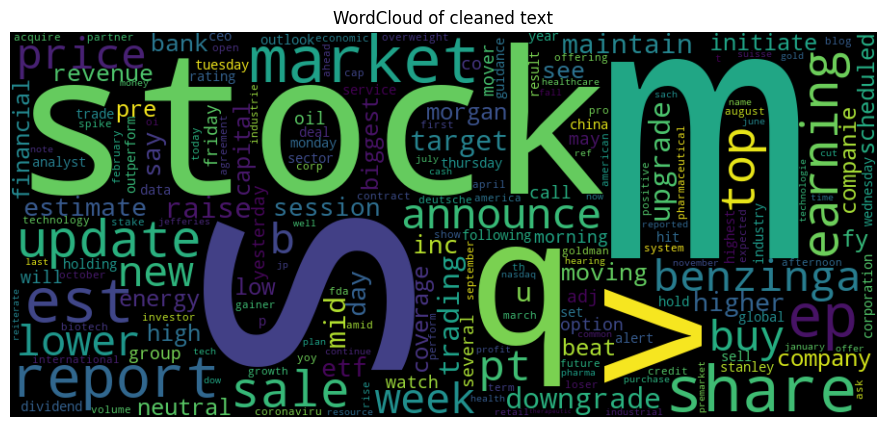

Top global TF-IDF keywords (example):
['agilent' 'technologies' 'vs est' 'vs' 'est' 'to' 'for' 'of' 'on' 'eps'] 



In [23]:
all_text = " ".join(df['clean'].dropna().astype(str).tolist())

wc = WordCloud(width=900, height=400, collocations=False).generate(all_text)

plt.figure(figsize=(12,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of cleaned text')
plt.show()

from collections import Counter

token_counts = Counter([tok for toks in df['tokens'].dropna() for tok in toks])
token_counts.most_common(30)

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(max_df=0.9, min_df=3, max_features=5000, ngram_range=(1,2))
tfidf_matrix = tfidf.fit_transform(df['clean'].fillna(''))

feature_names = np.array(tfidf.get_feature_names_out())

def top_tfidf_words(row, top_n=10):
    row_vec = tfidf.transform([row])
    sorted_nzs = np.argsort(row_vec.toarray()).flatten()[::-1][:top_n]
    return feature_names[sorted_nzs]

print("Top global TF-IDF keywords (example):")
print(top_tfidf_words(" ".join(df['clean'].dropna().head(500))), "\n")


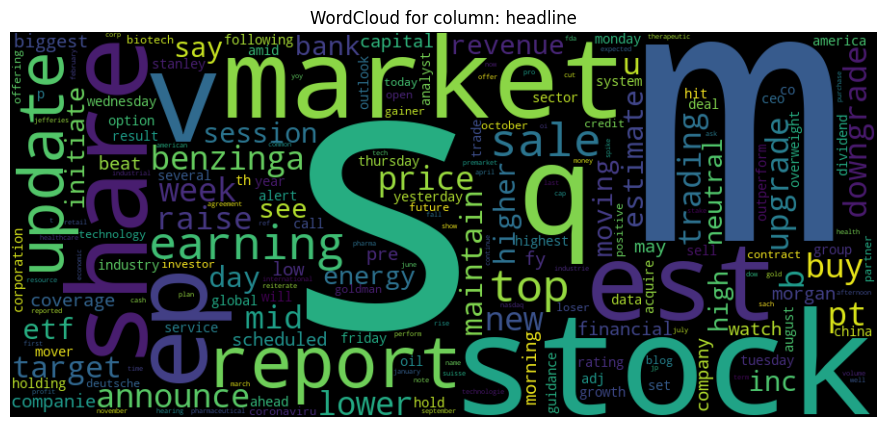

[('for', 239920), ('the', 213326), ('stocks', 161776), ('est', 140650), ('eps', 128917), ('from', 120807), ('market', 120560), ('shares', 114315), ('and', 113931), ('reports', 108711), ('update', 91723), ('earnings', 87399), ('with', 84258), ('sales', 79648), ('top', 79633), ('benzinga', 74516), ('week', 69572), ('announces', 66591), ('price', 64407), ('buy', 64374), ('mid', 62263), ('downgrades', 61959), ('trading', 61183), ('raises', 57802), ('upgrades', 56811), ('are', 56660), ('target', 54717), ('maintains', 52961), ('down', 50063), ('higher', 48286)]

Top global TF-IDF keywords (example):
['agilent' 'technologies' 'vs est' 'vs' 'est' 'to' 'for' 'of' 'on' 'eps'] 



In [24]:
# -------------------------------
# 1. Choose the text column
# -------------------------------
TEXT_COLUMN = "headline"   # <-- change this to your column

if TEXT_COLUMN not in df.columns:
    raise ValueError(f"Column '{TEXT_COLUMN}' does not exist in df.\nAvailable columns: {df.columns.tolist()}")


# -------------------------------
# 2. Clean text
# -------------------------------
import re

def fast_clean_text(text_series):
    return (
        text_series.astype(str)
        .str.lower()
        .str.replace(r'[^a-zA-Z\s]', ' ', regex=True)
        .str.replace(r'\s+', ' ', regex=True)
        .str.strip()
    )

df["clean"] = fast_clean_text(df[TEXT_COLUMN])


# -------------------------------
# 3. Simple tokenizer (fast)
# -------------------------------
def simple_tokenizer(text):
    return [w for w in text.split() if len(w) > 2]

df["tokens"] = df["clean"].fillna("").apply(simple_tokenizer)


# -------------------------------
# 4. WordCloud
# -------------------------------
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join(df["clean"].dropna().astype(str).tolist())

wc = WordCloud(width=900, height=400, collocations=False).generate(all_text)

plt.figure(figsize=(12,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title(f"WordCloud for column: {TEXT_COLUMN}")
plt.show()


# -------------------------------
# 5. Token frequency (Top 30)
# -------------------------------
from collections import Counter

token_counts = Counter([tok for toks in df["tokens"].dropna() for tok in toks])
print(token_counts.most_common(30))


# -------------------------------
# 6. TF-IDF (Top Keywords)
# -------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(
    max_df=0.9,
    min_df=3,
    max_features=5000,
    ngram_range=(1,2)
)

tfidf_matrix = tfidf.fit_transform(df["clean"].fillna(""))
feature_names = np.array(tfidf.get_feature_names_out())

def top_tfidf_words(row, top_n=10):
    row_vec = tfidf.transform([row])
    sorted_nzs = np.argsort(row_vec.toarray()).flatten()[::-1][:top_n]
    return feature_names[sorted_nzs]

print("\nTop global TF-IDF keywords (example):")
print(top_tfidf_words(" ".join(df["clean"].dropna().head(500))), "\n")


In [25]:
# =======================
# TOPIC MODELING WITH LDA
# =======================

from gensim import corpora
import gensim
import matplotlib.pyplot as plt

# --- 1. PREPARE TEXTS ---
# Ensure tokens exist and are valid lists
texts = df['tokens'].dropna().tolist()
texts = [t if isinstance(t, list) else str(t).split() for t in texts]


In [26]:
# --- 2. CREATE DICTIONARY ---
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=50000)

# --- 3. BAG OF WORDS ---
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
# --- 4. TRAIN LDA MODEL ---
NUM_TOPICS = 8
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [29]:
# PUBLISHER-LEVEL KEYWORD ANALYSIS
# ==================================

if "publisher" in df.columns:
    from sklearn.feature_extraction.text import TfidfVectorizer
    import numpy as np

    top_publishers = df['publisher'].value_counts().head(10).index.tolist()
    publisher_keywords = {}

    for pub in top_publishers:
        subset = df[df['publisher'] == pub]
        if subset.empty:
            continue

        tfidf_local = TfidfVectorizer(
            max_df=0.9,
            min_df=2,
            ngram_range=(1,2),
            max_features=2000
        )
        matrix = tfidf_local.fit_transform(subset['clean'].fillna(""))
        scores = np.asarray(matrix.sum(axis=0)).ravel()
        terms = np.array(tfidf_local.get_feature_names_out())

        top_idx = np.argsort(scores)[-10:][::-1]
        publisher_keywords[pub] = terms[top_idx].tolist()

    # Print results
    print("\n====== TOP KEYWORDS PER PUBLISHER ======")
    for pub, kws in publisher_keywords.items():
        print(f"\nPublisher: {pub}")
        print("Top Keywords:", kws)

else:
    print("No 'publisher' column found — skipping publisher analysis.")


# ============================
# SAVE ENRICHED DATASET
# ============================
df.to_csv("eda_enriched.csv", index=False)
print("\nSaved enriched dataset with tokens + topics → eda_enriched.csv")


====== TOP KEYWORDS PER PUBLISHER ======

Publisher: Paul Quintaro
Top Keywords: ['vs', 'est', 'vs est', 'to', 'of', 'eps', 'reports', 'eps vs', 'sales', 'reports eps']

Publisher: Lisa Levin
Top Keywords: ['stocks', 'for', 'benzinga', 'biggest', 'market', 'top', 'movers', 'benzinga top', 'in', 'session']

Publisher: Benzinga Newsdesk
Top Keywords: ['estimate', 'to', 'of', 'the', 'eps', 'sales', 'stocks', 'in', 'shares', 'new']

Publisher: Charles Gross
Top Keywords: ['to', 'of', 'for', 'in', 'vs', 'option', 'alert', 'option alert', 'on', 'ask']

Publisher: Monica Gerson
Top Keywords: ['for', 'earnings', 'scheduled', 'earnings scheduled', 'scheduled for', 'top', 'benzinga', 'benzinga top', 'the', 'stocks']

Publisher: Eddie Staley
Top Keywords: ['to', 'vs', 'est', 'of', 'vs est', 'announces', 'eps', 'reports', 'on', 'for']

Publisher: Hal Lindon
Top Keywords: ['vs', 'est', 'vs est', 'to', 'reports', 'eps', 'of', 'eps vs', 'reports eps', 'announces']

Publisher: ETF Professor
Top Keywo